# NASA Common Data Format (CDF) Access Methods in Python

Reading NASA Common Data Format files is an essential part of the research workflow of many graduate students and researchers in space-related disciplines. Python is increasingly popular for data analysis in these fields, but there is no official CDF access software for Python. 

### Existing Tools

Several unofficial packages have been developed:

* [pycdf](https://spacepy.github.io/pycdf.html) - requires manual download, compile and install NASA CDF C library
* [pysatCDF](https://github.com/pysat/pysatCDF) - bundles NASA CDF C library code, compiles it as part of Python installation
* [cdflib](https://github.com/MAVENSDC/cdflib) - do not need NASA CDF C library


### CDFlib

CDFlib is a particularly interesting package because it does not require the NASA CDF C library. This significantly reduces the barrier for researchers (including many student researchers) who have not had training in compiled programming languages or otherwise may not be comfortable compiling C source code.

### What is this document

This document is my notes and possibly a tutorial on transitioning from pycdf to cdflib. I have used pycdf interface for a long time and trained about a dozen students with it. My open source libraries also depend on the pycdf interface. I want to learn cdflib well enough to teach it to students so they need less of my help installing things on their computers, and I want to transition my open source libraries to cdflib so that it is easier to install them as well ( e.g. for automated testing via [TravisCI](https://travis-ci.org/) )

### Example research task

To show an example of using pycdf vs. cdflib, I will use both tools to extract the disturbance storm time index (DST, an measure of the overall geomagnetic activity in the earth's polar regions) for a moderate geomagnetic storm (May 29-30, 2010)

# Imports and Global Settings

In [26]:
import os,tempfile,datetime
from collections import OrderedDict
import requests
import numpy as np
import matplotlib.pyplot as plt
from spacepy import pycdf
import cdflib

dt = datetime.datetime(2010,5,29)

# Download a CDF file (so we have something to work with)

In [9]:
# We'll access NASA OMNIWeb like we would in a web browser (through HTTPS)
# here we construct the URL which points to the data file
base_url = 'https://spdf.gsfc.nasa.gov/pub/data'

#Some helper functions which create the directory path given a particular
#python datetime
def omni_hourly_subdir(dt):
    return 'omni/omni_cdaweb/hourly/{}'.format(dt.year)
def omni_hourly_cdffn(dt): 
    return 'omni2_h0_mrg1hr_{}{:02d}01_v01.cdf'.format(dt.year,(1 if dt.month < 7 else 7))

#Put together the full URL
cdffn = omni_hourly_cdffn(dt)
cdfsubdir = omni_hourly_subdir(dt)
url = base_url+'/'+cdfsubdir+'/'+cdffn

#Use the requests library to access the URL via an HTTP GET request
response = requests.get(url)

#Create a temporary directory where the data will be saved (on Linux this is in /tmp)
local_cdfdir = os.path.join(tempfile.gettempdir(),'pycdf2cdflib')
if not os.path.exists(local_cdfdir):
    os.makedirs(local_cdfdir)
local_cdffn = os.path.join(local_cdfdir,cdffn)

#Write the data from HTTP response to the local file
with open(local_cdffn,'wb') as f:
    f.write(response.content)
    
print('Downloaded CDF file {} to {}'.format(url,local_cdffn))


Downloaded CDF file https://spdf.gsfc.nasa.gov/pub/data/omni/omni_cdaweb/hourly/2010/omni2_h0_mrg1hr_20100101_v01.cdf to /tmp/pycdf2cdflib/omni2_h0_mrg1hr_20100101_v01.cdf



# Extract Data with PyCDF 

In [14]:
def pycdf_extract_var(cdf_filename,varname):
    """Extract a variable, the associated times, and the variable's
    metadata from a CDF using pycdf"""
    with pycdf.CDF(cdf_filename) as cdf:
        dtimes = cdf['Epoch'][:]
        data = cdf[varname][:]
        #Extract the metadata and store in a dictionary
        metadata = {}
        metadata['description'] = cdf[varname].attrs['CATDESC']
        metadata['units'] = cdf[varname].attrs['UNITS']
    return dtimes,data,metadata

pycdf_t,pycdf_dst,pycdf_meta = pycdf_extract_var(local_cdffn,'DST')

# Extract Data with CDFlib

In [22]:
def cdflib_extract_vardata(cdf_filename,varname):
    """Extract a variable, the associated times, and the variable's metadata
    from a CDF using cdflib"""
    cdf = cdflib.CDF(cdf_filename)
    #Extact the numerical representation of the
    #time
    cdftime = cdf.varget('Epoch')
    
    #The Epoch variable data can either be a numpy
    #float array (if the CDF epoch type is CDF_EPOCH)
    #or a numpy complex array (if the CDF epoch type is CDF_EPOCH_16)
    epoch_info = cdf.varinq('Epoch')
    epoch_type = epoch_info['Data_Type_Description']
    if epoch_type!='CDF_EPOCH':
        print('Epoch type is {}'.format(epoch_type))
        
    #cdflib.cdfepoch is another name for cdflib.epochs.CDFEpoch
    #which is a container class
    
    #The to_datetime method converts an epoch's numerical representation
    #to a Python datetime
    dtimes = cdflib.cdfepoch().to_datetime(cdftime,to_np=True)
    
    #the to_np switch toggles whether a list (False) or numpy array (True)
    #of datetimes is returned. I return an array since that
    #is what pycdf does.
    data = cdf.varget(varname)
    #Extract the metadata and store in a dictionary
    metadata = {}
    metadata['description'] = cdf.attget('CATDESC',varname)
    metadata['units'] = cdf.attget('UNITS',varname)
    return dtimes,data,metadata

cdflib_t,cdflib_dst,cdflib_meta = cdflib_extract_vardata(local_cdffn,'DST')


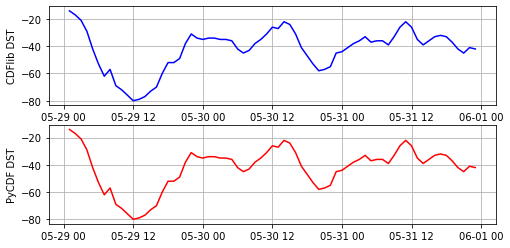

In [32]:
#Graphically verify that nothing majorly different is happening
f = plt.figure(figsize=(8,4))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

startdt,enddt = datetime.datetime(2010,5,29,0),datetime.datetime(2010,6,1,0)
cdflib_mask = np.logical_and(cdflib_t>startdt,cdflib_t<enddt)
pycdf_mask = np.logical_and(pycdf_t>startdt,pycdf_t<enddt)
ax1.plot(cdflib_t[cdflib_mask],cdflib_dst[cdflib_mask],'b-')
ax1.set_ylabel('CDFlib DST')
ax2.plot(pycdf_t[pycdf_mask],pycdf_dst[pycdf_mask],'r-')
ax2.set_ylabel('PyCDF DST')

for ax in [ax1,ax2]:
    ax.grid(True)
